# Regressão Linear com PyTorch

## Objetivo

Este exemplo utiliza regressão linear para estimar o comprimento das sépalas da íris a partir do seu comprimento das pétalas.
Utiliza-se
- o cálculo do gradiente automático do PyTorch, porém
- a função de perda e
- atualização dos parâmetros é feita de forma explícita.
- A rede é criada com uma camada nn.Linear()

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinear_Otimizacao.png)

## Importação dos pacotes

In [1]:
# # http://pytorch.org/
# from os.path import exists
# #!pip install numpy==1.15.0
# !pip install -q install wheel==0.34.2 setuptools

# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# print(get_abbr_impl())
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# #https://download.pytorch.org/whl/cpu/torch-0.4.1.post2-cp37-cp37m-linux_x86_64.whl
# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1.post2-{platform}-linux_x86_64.whl torchvision
# import torch

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from sklearn.datasets import load_iris

import torch
from torch import nn, optim
from torch.autograd import Variable

torch.manual_seed(1234)

## Leitura dos dados

In [3]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_train = data[:,0:1].astype(np.float32)
y_train = data[:,1:2].astype(np.float32)

n_samples = x_train.shape[0]
print('x_train.shape:',x_train.shape, x_train.dtype)
print('y_train.shape:',y_train.shape, y_train.dtype)

print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train.shape: (50, 1) float32
y_train.shape: (50, 1) float32
x_train[:5]:
 [[7. ]
 [6.4]
 [6.9]
 [5.5]
 [6.5]]
y_train[:5]:
 [[4.7]
 [4.5]
 [4.9]
 [4. ]
 [4.6]]


### Normalização dos dados

In [4]:
x_train -= x_train.min()
x_train /= x_train.max()
y_train -= y_train.min()
y_train /= y_train.max()


In [5]:
print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train[:5]:
 [[1.        ]
 [0.71428573]
 [0.952381  ]
 [0.28571424]
 [0.7619048 ]]
y_train[:5]:
 [[0.80952376]
 [0.71428573]
 [0.90476197]
 [0.4761905 ]
 [0.7619048 ]]


In [6]:
x_train_bias = np.hstack([np.ones(shape=(n_samples,1)), x_train]) #Criação de um x_train com bias e valores da variável x0

In [7]:
x_train_bias

array([[1.        , 1.        ],
       [1.        , 0.71428573],
       [1.        , 0.95238101],
       [1.        , 0.28571424],
       [1.        , 0.76190478],
       [1.        , 0.38095227],
       [1.        , 0.66666675],
       [1.        , 0.        ],
       [1.        , 0.80952376],
       [1.        , 0.14285702],
       [1.        , 0.047619  ],
       [1.        , 0.47619051],
       [1.        , 0.52380949],
       [1.        , 0.57142848],
       [1.        , 0.33333325],
       [1.        , 0.85714275],
       [1.        , 0.33333325],
       [1.        , 0.42857149],
       [1.        , 0.61904752],
       [1.        , 0.33333325],
       [1.        , 0.47619051],
       [1.        , 0.57142848],
       [1.        , 0.66666675],
       [1.        , 0.57142848],
       [1.        , 0.71428573],
       [1.        , 0.80952376],
       [1.        , 0.90476197],
       [1.        , 0.85714275],
       [1.        , 0.52380949],
       [1.        , 0.38095227],
       [1.

In [8]:
print('x_train_bias.shape:',x_train_bias.shape, x_train_bias.dtype)

x_train_bias.shape: (50, 2) float64


In [9]:
#Transformação em Tensores

x_train_bias = torch.FloatTensor(x_train_bias)
y_train      = torch.FloatTensor(y_train)
print(y_train[0:5])

tensor([[0.8095],
        [0.7143],
        [0.9048],
        [0.4762],
        [0.7619]])


## Model

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinearNeuronio.png)

In [10]:
 #Criar rede neural com 2 entradas (bias e x0) e uma saída (y)
model = torch.nn.Linear(in_features=2, out_features=1, bias=False)

In [11]:
#Parâmetros do modelo (peso e biais, nesse caso apenas pesos pois o bias foi definido como False e foi criado a parte)

model.state_dict()

OrderedDict([('weight', tensor([[-0.6661, -0.1387]]))])

In [12]:
# Pesos do modelo
model.weight.data

tensor([[-0.6661, -0.1387]])

### Verificando a inicialização dos parâmetros

In [13]:
model.weight.data = torch.zeros(1,2) # Zerando os pesos
torch.nn.init.uniform(model.weight.data, -0.1, 0.1) # Transformando os pesos em valores aleatórios entre -0.1 e 0.1
model.weight

<ipython-input-13-11d6f9425a82>:2: FutureWarning: `nn.init.uniform` is now deprecated in favor of `nn.init.uniform_`.
  torch.nn.init.uniform(model.weight.data, -0.1, 0.1) # Transformando os pesos em valores aleatórios entre -0.1 e 0.1


Parameter containing:
tensor([[-0.0480, -0.0267]], requires_grad=True)

In [14]:
#Novos pesos
model.weight.data

tensor([[-0.0480, -0.0267]])

### Testando o predict da rede

In [15]:
xx = torch.ones((5,2))
xx

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])

In [16]:
model.weight.data

tensor([[-0.0480, -0.0267]])

In [17]:
#Valores de ypred  (x . wT) --> -0,048 + (-0,0267) = -0,0747
model(Variable(xx))

tensor([[-0.0747],
        [-0.0747],
        [-0.0747],
        [-0.0747],
        [-0.0747]], grad_fn=<MmBackward0>)

## Treinamento

In [18]:
num_epochs = 100
learning_rate = 0.5
for epoch in range(num_epochs):
    inputs = Variable(x_train_bias)
    target = Variable(y_train)
    print(f'Época {epoch}')
    # forward - predict
    out = model(x_train_bias)

    #loss: cálculo da função de perda
    loss = torch.pow(out - target, 2).mean()


    # backward propagation - cálculo gradiente
    loss.backward()

    # gradiente descendente
    model.weight.data = model.weight.data - learning_rate * model.weight.grad.data

    print(f'Gradiente inicial: {model.weight.grad.data}')
    # zeragem parâmetros próximo cálculo do gradiente
    model.weight.grad.data.zero_()
    print(f'Gradiente zerado: {model.weight.grad.data}')
    print(f'w na época {epoch}: {model.weight.data}')
    # verbose
    if (epoch+1) % 20 == 0:
        print()
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.item()))
    print()

Época 0
Gradiente inicial: tensor([[-1.3224, -0.7368]])
Gradiente zerado: tensor([[0., 0.]])
w na época 0: tensor([[0.6132, 0.3417]])

Época 1
Gradiente inicial: tensor([[0.3635, 0.1385]])
Gradiente zerado: tensor([[0., 0.]])
w na época 1: tensor([[0.4314, 0.2725]])

Época 2
Gradiente inicial: tensor([[-0.0683, -0.0827]])
Gradiente zerado: tensor([[0., 0.]])
w na época 2: tensor([[0.4656, 0.3139]])

Época 3
Gradiente inicial: tensor([[ 0.0408, -0.0240]])
Gradiente zerado: tensor([[0., 0.]])
w na época 3: tensor([[0.4452, 0.3258]])

Época 4
Gradiente inicial: tensor([[ 0.0118, -0.0369]])
Gradiente zerado: tensor([[0., 0.]])
w na época 4: tensor([[0.4392, 0.3443]])

Época 5
Gradiente inicial: tensor([[ 0.0182, -0.0315]])
Gradiente zerado: tensor([[0., 0.]])
w na época 5: tensor([[0.4302, 0.3601]])

Época 6
Gradiente inicial: tensor([[ 0.0156, -0.0310]])
Gradiente zerado: tensor([[0., 0.]])
w na época 6: tensor([[0.4224, 0.3755]])

Época 7
Gradiente inicial: tensor([[ 0.0153, -0.0293]])
G

## Avaliação

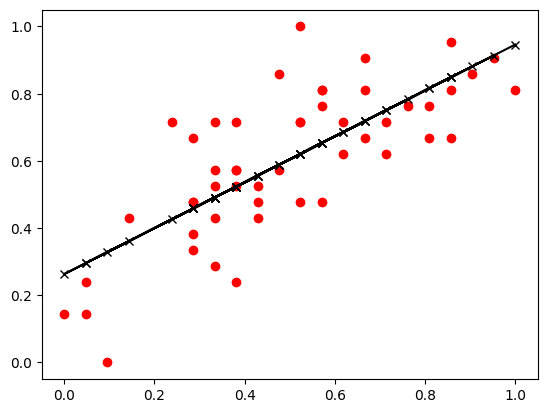

In [19]:
y_pred = model(Variable(x_train_bias))
plt.plot(x_train, y_train.numpy(), 'ro', label='Original data')
plt.plot(x_train, y_pred.data.numpy(), 'kx-', label='Fitting Line')
plt.show()

### Acessando os parâmetros

In [20]:
w_dic = model.state_dict()
w_dic

OrderedDict([('weight', tensor([[0.2631, 0.6830]]))])

### Parâmetros ótimos, solução analítica

In [21]:
x_bias = x_train_bias
y = y_train
x_bias_t = torch.t(x_bias)
w_opt = (torch.inverse(x_bias_t.mm(x_bias)).mm(x_bias_t)).mm(y)
print(torch.t(w_opt))

tensor([[0.2613, 0.6865]])


# Exercícios

- 1) Por que no final da varredura do laço de treinamento, a perda é impressa utilizando
   `loss.data[0]`? Por que precisa do `data` e por que precisa da indexação por zero?

**A necessidade de utilizar o loss.data se dá pelo fato da variável loss ser um tensor. No mais não foi necessário indexar o loss.data[0] para obter o valor, apenas loss.data foi suficiente**
   

- 2) Calcule e imprima o valor da perda (MSE) fazendo o predict da rede com os pesos já
   treinados.

In [22]:
#Parametros do modelo treinado após as 100 épocas
model.state_dict()


OrderedDict([('weight', tensor([[0.2631, 0.6830]]))])

In [23]:
# Função custo (perda) após o treinamento do modelo

y_pred = model(Variable(x_train_bias))

loss = torch.pow(y_pred - y_train, 2).mean()
loss.data

tensor(0.0212)

- 3) Crie duas listas `w0_list` e `w1_list` para guardar a evolução dos valores dos
   parâmetros durante o laço de treinamento.
   Modifique o exemplo do gráfico tipo **scatter plot** para visualizar a variação
   dos parâmetros do modelo duas dimensões.
   Marque neste gráfico o valor ótimo do parâmetro dado pela solução
   analítica.

In [24]:
model.weight.data = torch.zeros(1,2) # Zerando os pesos
torch.nn.init.uniform(model.weight.data, -0.1, 0.1) # Transformando os pesos em valores aleatórios entre -0.1 e 0.1
model.weight

<ipython-input-24-11d6f9425a82>:2: FutureWarning: `nn.init.uniform` is now deprecated in favor of `nn.init.uniform_`.
  torch.nn.init.uniform(model.weight.data, -0.1, 0.1) # Transformando os pesos em valores aleatórios entre -0.1 e 0.1


Parameter containing:
tensor([[-0.0883,  0.0401]], requires_grad=True)

In [25]:
model.weight.data[0][1]

tensor(0.0401)

Epoch[20/100], loss: 0.022454
Epoch[40/100], loss: 0.021355
Epoch[60/100], loss: 0.021196
Epoch[80/100], loss: 0.021173
Epoch[100/100], loss: 0.021170


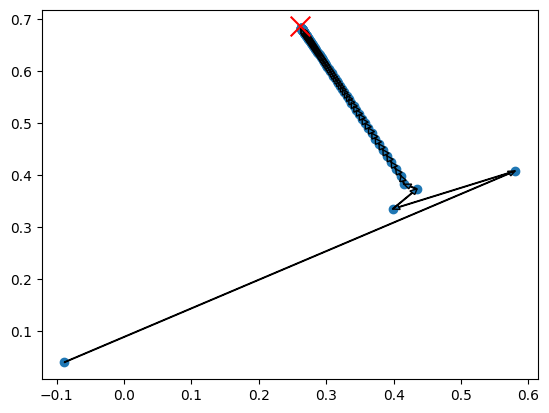

In [26]:
num_epochs = 100
learning_rate = 0.5
w0_list=[]
w1_list=[]

for epoch in range(num_epochs):
    inputs = Variable(x_train_bias)
    target = Variable(y_train)

    # forward - predict
    out = model(inputs)
    w0_list.append(model.weight.data[0][0])
    w1_list.append(model.weight.data[0][1])
    #loss cálculo da função de perda
    loss = torch.pow(out - target, 2).mean()


    # backward propagation - cálculo gradiente
    loss.backward()

    # gradiente descendente
    model.weight.data = model.weight.data - learning_rate * model.weight.grad.data

    # zeragem parâmetros próximo cálculo do gradiente
    model.weight.grad.data.zero_()

    # verbose
    if (epoch+1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.data))


plt.scatter(w0_list,w1_list)
w0_old = None
for (w0,w1) in zip(w0_list,w1_list):
    if w0_old:
        plt.arrow(w0_old, w1_old, w0-w0_old, w1-w1_old,
                  head_length=0.01,head_width=0.01,shape='full',
                  length_includes_head=True)
    w0_old,w1_old = w0,w1

plt.scatter(x=w_opt[0],y=w_opt[1],marker='x',color='red',s=200)

# Aprendizados

O Pytorch apresenta funções na sua biblioteca que auxiliam na criação e treinamento de redes neurais.

Torch.nn.Linear foi utilizada para criar uma Rede Neural com modelo linear.

A função backward() é utilizada para calcular o gradiente descendente.

Importante destacar que após cada época do laço de treinamento é necessário zerar o gradiente descendente acumulado da época anterior.

A médida que o treinamento passa pelas épocas, os valores dos pesos otimizados se aproximam da solução análitica para os pesos.


#Conceitos fundamentais

**Redes Neurais:**: Uma rede neural é um programa, ou modelo, de aprendizado de máquina que toma decisões de uma forma semelhante ao cérebro humano, utilizando processos que imitam a maneira como os neurônios biológicos trabalham juntos para identificar fenômenos, ponderar opções e chegar a conclusões.

Toda rede neural é composta por camadas de nós, ou neurônios artificiais: uma camada de entrada, uma ou mais camadas ocultas e uma camada de saída. Cada nó se conecta a outros e possui seu próprio peso e limiar associados

**Gradiente Descendente:**O gradiente descendente é um algoritmo de otimização comumente usado para treinar modelos de aprendizado de máquina e redes neurais. Ele treina modelos de aprendizado de máquina ao minimizar os erros entre os resultados previstos e os reais.

Os conceitos de Redes Neurais e gradientes descendentes foram utilizados nesse projeto para realizar um algoritmo de regressão linear com base nos dados Iris.


**Etapas do Laço de treinamento:**
- Predição dos valores com base nos dados de entrada (X)

- Cálculo da função perda. MSE foi usada no projeto.
  
  Perda de entropia cruzada / binária poderia ser usada para modelos de classificação.

- Cálculo do gradiente (utilizando a função perda e o learning rate)

- Atualização dos pesos iniciais usando o gradiente calculado

**Learning rate:** Taxa de aprendizagem. Parâmetro fundamental para o cálculo o gradiente descendente. Pequenos valores de Learning rate podem levar a um aprendizado mais lenta (mais épocas necessárias), grandes valores podem levar a um treinamento instável com dificuldade para convergir para a melhor solução
